门控循环单元

门控循环单元与普通的循环神经网络之间的关键区别在于： 门控循环单元支持隐状态的门控。 <br>
也就是模型有专门的机制来确定应该何时更新隐状态，以及应该何时重置隐状态。 <br>
并且这些机制是可学习的，可以一定程度上解决一些问题 <br>
例如，如果第一个词元非常重要，模型将学会在第一次观测之后不更新隐状态；同样，模型也可以学会跳过不相关的临时观测；最后，模型还将学会在需要的时候重置隐状态。

门控也有各种类型

重置门（reset gate）和更新门（update gate）

我们把它们设计成(0,1)区间中的向量，这样我们就可以进行凸组合。 <br>
重置门允许我们控制“可能还想记住”的过去状态的数量； 更新门将允许我们控制新状态中有多少个是旧状态的副本。

将重置门Rₜ与中的常规隐状态更新机制集成，也就是控制之前隐状态对当前候选隐状态的影响程度，得到在时间步的候选隐状态(candidate hidden state) $\tilde{H}_t \in \mathbb{R}^{n \times h}$

$$
\tilde{H}_t = \tanh(X_t W_{xh} + (R_t \odot H_{t-1}) W_{hh} + b_h),
$$

其中 $W_{xh} \in \mathbb{R}^{d \times h}$ 和 $W_{hh} \in \mathbb{R}^{h \times h}$ 是权重参数，$b_h \in \mathbb{R}^{1 \times h}$ 是偏置项，符号 $\odot$ 是Hadamard积（按元素乘积）运算符。在这里，我们使用tanh非线性激活函数来确保候选隐状态中的值保持在区间(-1, 1)中。

与(8.4.5)相比，(9.1.2)中的Rₜ和Hₜ₋₁的元素相乘可以减少以往状态的影响。每当重置门Rₜ中的项接近1时，我们恢复一个如(8.4.5)中的普通的循环神经网络。对于重置门Rₜ中所有接近0的项，候选隐状态是以Xₜ作为输入的多层感知机的结果。因此，任何预先存在的隐状态都会被重置为默认值。

以上得到的是候选隐状态，还要依据更新门来决定新的候选隐状态与旧隐状态如何结合形成最终的隐状态

这一步确定新的隐状态Hₜ ∈ ℝⁿˣʰ 在多大程度上来自旧的状态Hₜ₋₁和新的候选状态 $\tilde{H}_t$。更新门Zₜ仅需要在 Hₜ₋₁和 $\tilde{H}_t$ 之间进行按元素的凸组合就可以实现这个目标。这就得出了门控循环单元的最终更新公式：

$$
H_t = Z_t \odot H_{t-1} + (1 - Z_t) \odot \tilde{H}_t.
$$

每当更新门Zₜ接近1时，模型就倾向只保留旧状态。此时，来自Xₜ的信息基本上被忽略，从而有效地跳过了依赖链条中的时间步t。相反，当Zₜ接近0时，新的隐状态Hₜ就会接近候选隐状态 $\tilde{H}_t$。这些设计可以帮助我们处理循环神经网络中的梯度消失问题，并更好地捕获时间步距离很长的序列的依赖关系。例如，如果整个子序列的所有时间步的更新门都接近于1，则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。

虽然重置门和更新门看起来都在控制旧状态的影响，重置门侧重于旧隐藏状态对候选隐状态计算的影响，侧重于需要忘记过去不相关信息时；更新门侧重于控制最终隐状态中旧隐藏状态的影响

也就是<br>
重置门可以选择性地重置隐状态中的特定维度，帮助模型创建与过去状态不同的新表示<br>
更新门控制整体信息流动和保留程度，助模型在长序列中保持稳定的记忆

或者说<br>
重置门有助于捕获序列中的短期依赖关系；<br>
更新门有助于捕获序列中的长期依赖关系

首先读取数据集

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

初始化模型参数

下一步是初始化模型参数。 我们从标准差为0.01的高斯分布中提取权重， 并将偏置项设为0，超参数num_hiddens定义隐藏单元的数量， 实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [ ]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 将所有参数设置为需要计算梯度的操作
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

定义模型<br>
现在我们将定义隐状态的初始化函数init_gru_state。 与 8.5节中定义的init_rnn_state函数一样， 此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零

In [4]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

定义门控循环单元模型

In [5]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

训练和预测的工作方式与 8.5节完全相同。 训练结束后，我们分别打印输出训练集的困惑度， 以及前缀“time traveler”和“traveler”的预测序列上的困惑度。

perplexity 1.1, 25926.8 tokens/sec on cuda:0
time traveller after the pauserequired for the proper assimilati
travelleryou can show black is white by argument said filby


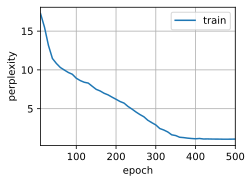

In [6]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

也可以通过高级API直接完成简洁实现

这能运行更快是因为这使用了编译好的运算符而不是Python

perplexity 1.0, 270808.9 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


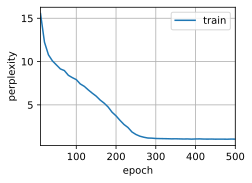

In [ ]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)  # GRU是内置的GRU层，能自动处理时序计算、门控逻辑等复杂操作
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)